### Import Modules & Basic Settings

In [1]:
import os, time
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Set Options

In [2]:
# GPU Setting
if torch.cuda.is_available():
    torch.cuda.set_device(1)
    device = "cuda:1"
else: 
    device = "cpu"
print('Device:', device)

# Number of CPU cores
num_cores = os.cpu_count()
print(f"Number of CPU Cores: {num_cores}")

# Base Directory
root_dir = os.getcwd()
print(f'Base Directory: {os.getcwd()}')

# Path to Data
image_data = '/data/image/'
train_data_path = root_dir+image_data+'train/'
# test_data_path = root_dir+image_data+'test/'

Device: cuda:1
Number of CPU Cores: 32
Base Directory: /home/jiwon/GalaxyClassification


In [3]:
# Hyper-Parameters Setting
criterion = torch.nn.CrossEntropyLoss()
batch_size = 32
max_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-5
val_interval = 1

### Load Train Data

In [4]:
# Set Label (Train)
train_df = pd.read_csv(os.path.join(train_data_path, 'training_solutions_rev1.csv'))
print(train_df.shape)
print(train_df.columns)

(61578, 38)
Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')


In [5]:
train_df['Label'] = train_df.iloc[:, 1:].idxmax(axis=1)
train_df = train_df[['GalaxyID', 'Label']]
print(train_df)

       GalaxyID     Label
0        100008  Class6.2
1        100023  Class6.2
2        100053  Class6.2
3        100078  Class1.1
4        100090  Class6.2
...         ...       ...
61573    999948  Class6.2
61574    999950  Class1.1
61575    999958  Class6.1
61576    999964  Class1.2
61577    999967  Class1.1

[61578 rows x 2 columns]


In [6]:
all_classes = [
    'Class1.1', 'Class1.2', 'Class1.3',
    'Class2.1', 'Class2.2',
    'Class3.1', 'Class3.2',
    'Class4.1', 'Class4.2',
    'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4',
    'Class6.1', 'Class6.2',
    'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7',
    'Class9.1', 'Class9.2', 'Class9.3',
    'Class10.1', 'Class10.2', 'Class10.3',
    'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6'
]
label_to_int = {label: idx for idx, label in enumerate(all_classes)}
train_df['Label_Converted'] = train_df['Label'].map(label_to_int)
print(train_df)

       GalaxyID     Label  Label_Converted
0        100008  Class6.2               14
1        100023  Class6.2               14
2        100053  Class6.2               14
3        100078  Class1.1                0
4        100090  Class6.2               14
...         ...       ...              ...
61573    999948  Class6.2               14
61574    999950  Class1.1                0
61575    999958  Class6.1               13
61576    999964  Class1.2                1
61577    999967  Class1.1                0

[61578 rows x 3 columns]


In [7]:
# Custom Dataset
class GalaxyDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f"{self.labels_df['GalaxyID'].iloc[idx]}.jpg")
        image = Image.open(img_name).convert('L')
        label = self.labels_df.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Data Transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [8]:
# Define Dataset & Data Loader
train_df, temp_df = train_test_split(train_df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Verify the split
print(f'Train set: {len(train_df)} samples')
print(f'Validation set: {len(val_df)} samples')
print(f'Test set: {len(test_df)} samples')

train_dataset = GalaxyDataset(train_data_path, train_df, transform=transform)
val_dataset = GalaxyDataset(train_data_path, val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)

Train set: 36946 samples
Validation set: 12316 samples
Test set: 12316 samples


In [9]:
# Extract First Batch
tr_batch_first = next(iter(train_dataset))
print(f'Image Shape: {tr_batch_first[0].shape}')
print(f'Label Type: {type(tr_batch_first[1])}')

Image Shape: torch.Size([1, 64, 64])
Label Type: <class 'numpy.int64'>


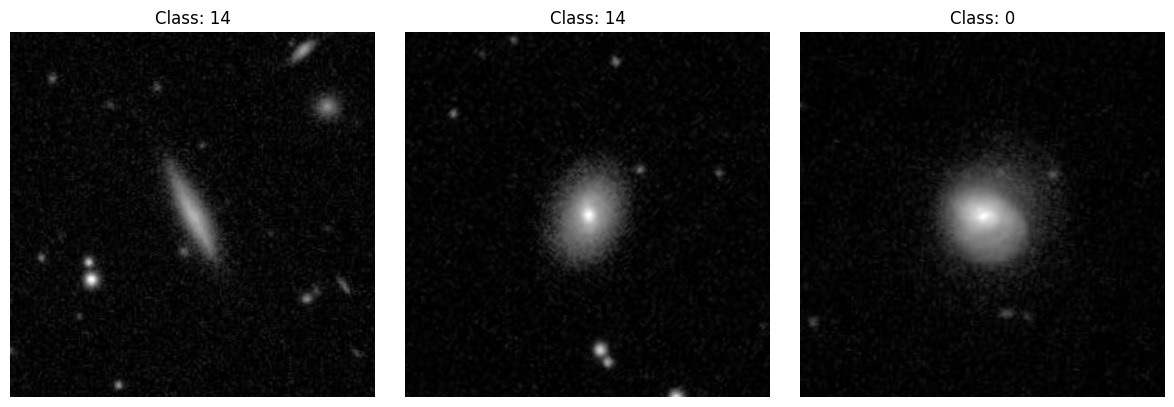

In [10]:
# Visualize: Train
visualize_num = 3
space = 0 if visualize_num%3==0 else 1
plt.figure(figsize=(12, 4*(visualize_num//3+space)))

for i in range(3):
    img_name = os.path.join(train_data_path, f"{train_df['GalaxyID'].iloc[i]}.jpg")
    image = Image.open(img_name).convert('L')
    label = val_df.iloc[i, -1]

    plt.subplot(visualize_num//3+space, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

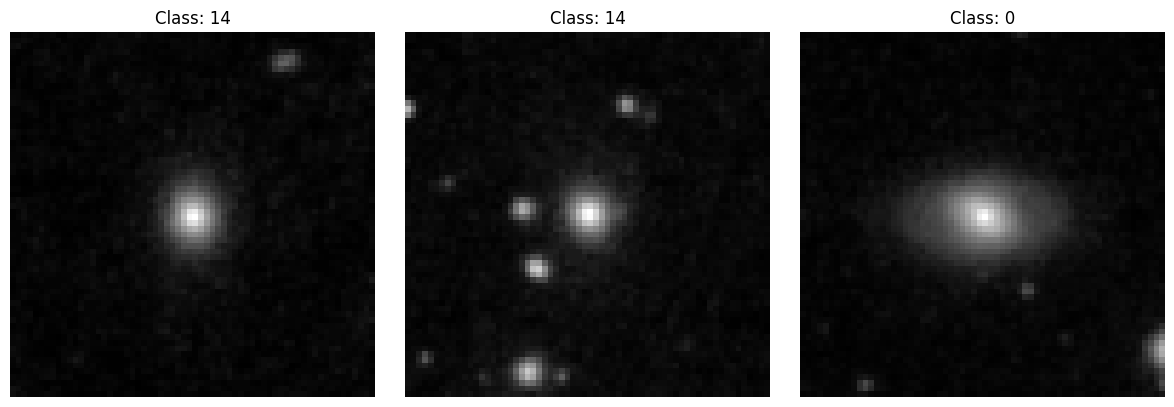

In [11]:
# Visualize: Val
visualize_num = 3
space = 0 if visualize_num%3==0 else 1
plt.figure(figsize=(12, 4*(visualize_num//3+space)))

train_loader_iter = iter(val_dataset)

for i in range(visualize_num):
    image, label = next(train_loader_iter)
    image = image.permute(1, 2, 0).numpy()

    plt.subplot(visualize_num//3+space, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Model

In [12]:
# class SimpleCNN(nn.Module): # 128x128
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(128 * 16 * 16, 512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 16 * 16)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [13]:
class SimpleCNN(nn.Module): # 64x64
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # The new input size for FC layer after 64x64 input size
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# # Hyper-Parameters Setting
# criterion = torch.nn.CrossEntropyLoss()
# batch_size = 32
# max_epochs = 100
# learning_rate = 1e-4
# weight_decay = 1e-5
# val_interval = 1

In [15]:
# Model, Optimizer, and Scheduler Setup
num_classes = 37
model = SimpleCNN(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [16]:
print('Device:', device)
print(torch.cuda.is_available())

Device: cuda:1
True


In [17]:
from tqdm import tqdm

# Initialize variables for tracking loss and metric values
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, epoch_metric_values, metric_values = [], [], []

# Training Loop
start_time = time.time()
num_epochs = 20

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss = 0.0
    correct_predictions, total_samples = 0, 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

         # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=running_loss/(len(progress_bar)), accuracy=correct_predictions / total_samples)

    # Calculate epoch average loss
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    epoch_loss_values.append(epoch_loss)
    epoch_metric_values.append(epoch_accuracy)
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} ({int(epoch_time)} sec)")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_accuracy = correct / total
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

    metric_values.append(validation_accuracy)

    if validation_accuracy > best_metric:
        best_metric = validation_accuracy
        best_metric_epoch = epoch + 1
        best_model_wts = model.state_dict()

    lr_scheduler.step()
    epoch_end_time = time.time()

# Save the model
torch.save(best_model_wts, os.path.join(root_dir,f'galaxy_cnn_model_final_64x64_{num_epochs}_epochs_grayscale.pth'))

# Total training time
total_time = time.time() - start_time
print()
print(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time//60} mins {int(total_time%60)} sec")

# Save loss and metric values
torch.save({
    'epoch_loss_values': epoch_loss_values,
    'epoch_metric_values': epoch_metric_values,
    'metric_values': metric_values
}, f'training_metrics_final_64x64_{num_epochs}_epochs_grayscale.pth')

Epoch [1/20], Loss: 1.0769, Accuracy: 0.5859 (45 sec)


Validation Accuracy: 0.6033


Epoch [2/20], Loss: 0.9517, Accuracy: 0.6059 (47 sec)


Validation Accuracy: 0.6290


Epoch [3/20], Loss: 0.9137, Accuracy: 0.6249 (47 sec)


Validation Accuracy: 0.6443


Epoch [4/20], Loss: 0.8801, Accuracy: 0.6349 (47 sec)


Validation Accuracy: 0.6560


Epoch [5/20], Loss: 0.8443, Accuracy: 0.6548 (45 sec)


Validation Accuracy: 0.6693


Epoch [6/20], Loss: 0.8169, Accuracy: 0.6662 (45 sec)


Validation Accuracy: 0.6644


Epoch [7/20], Loss: 0.7884, Accuracy: 0.6825 (47 sec)


Validation Accuracy: 0.7018


Epoch [8/20], Loss: 0.7633, Accuracy: 0.6941 (47 sec)


Validation Accuracy: 0.7003


Epoch [9/20], Loss: 0.7408, Accuracy: 0.7039 (47 sec)


Validation Accuracy: 0.6993


Epoch [10/20], Loss: 0.7232, Accuracy: 0.7111 (47 sec)


Validation Accuracy: 0.7197


Epoch [11/20], Loss: 0.7092, Accuracy: 0.7167 (47 sec)


Validation Accuracy: 0.7000


Epoch [12/20], Loss: 0.6968, Accuracy: 0.7234 (47 sec)


Validation Accuracy: 0.7129


Epoch [13/20], Loss: 0.6845, Accuracy: 0.7297 (48 sec)


Validation Accuracy: 0.7168


Epoch [14/20], Loss: 0.6775, Accuracy: 0.7312 (46 sec)


Validation Accuracy: 0.7301


Epoch [15/20], Loss: 0.6668, Accuracy: 0.7378 (48 sec)


Validation Accuracy: 0.7173


Epoch [16/20], Loss: 0.6607, Accuracy: 0.7391 (47 sec)


Validation Accuracy: 0.7343


Epoch [17/20], Loss: 0.6493, Accuracy: 0.7437 (48 sec)


Validation Accuracy: 0.7310


Epoch [18/20], Loss: 0.6441, Accuracy: 0.7443 (46 sec)


Validation Accuracy: 0.7283


Epoch [19/20], Loss: 0.6370, Accuracy: 0.7483 (48 sec)


Validation Accuracy: 0.7260


Epoch [20/20], Loss: 0.6311, Accuracy: 0.7522 (47 sec)


Validation Accuracy: 0.7205

Best accuracy: 0.734 at epoch 16; Total time consumed: 20.0 mins 44 sec


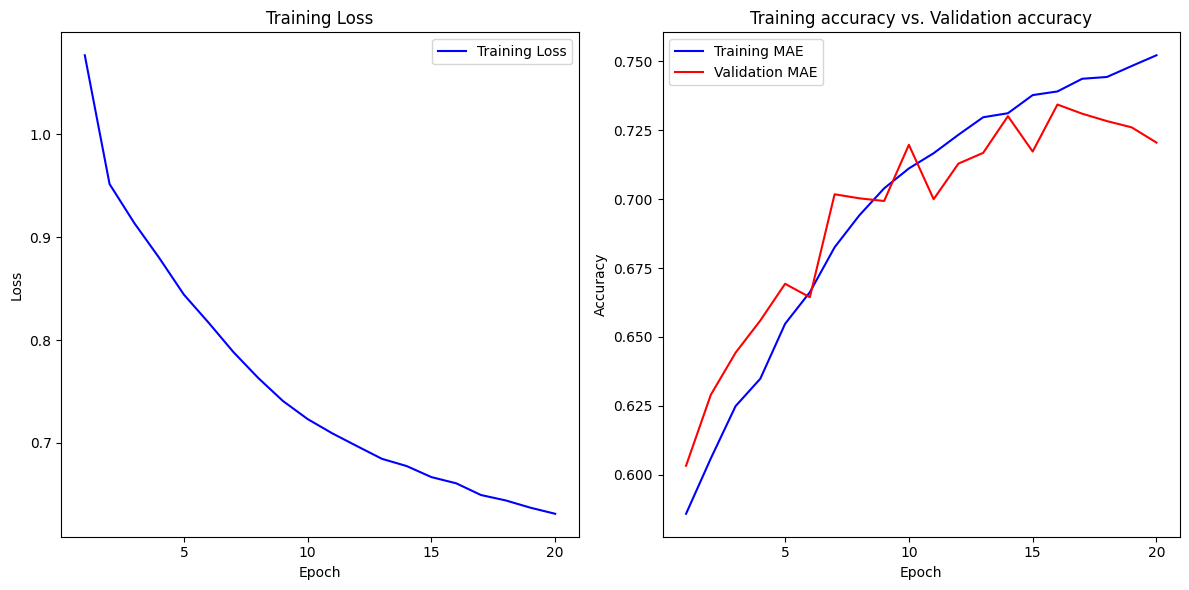

In [18]:
# Plotting the Results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[0].plot([i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values, label='Training Loss', color='blue')
axes[0].legend()

axes[1].set_title('Training accuracy vs. Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[1].plot([i + 1 for i in range(len(epoch_metric_values))], epoch_metric_values, label='Training MAE', color='blue')
axes[1].plot([val_interval * (i + 1) for i in range(len(metric_values))], metric_values, label='Validation MAE', color='red')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(root_dir, f"Performance_final_64x64_{num_epochs}_epochs_grayscale.png"), dpi=300)

### Inference

In [19]:
# Load Test Data
test_dataset = GalaxyDataset(train_data_path, test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)

# Load the Best Model Weights
model.load_state_dict(torch.load(os.path.join(root_dir, f"galaxy_cnn_model_final_64x64_{num_epochs}_epochs_grayscale.pth")))
model.eval()

# Perform Inference on Test Data
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Inference', leave=False):
        images, labels= images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert Predictions and True Labels to DataFrame
test_results_df = test_df.copy()
test_results_df['Predicted_Label'] = predictions
test_results_df['True_Label'] = true_labels

# Save the Results
np.savetxt(os.path.join(root_dir, f"Predictions_final_64x64_{num_epochs}_epochs_grayscale.txt"), predictions)
test_results_df.to_csv(os.path.join(root_dir, f"Test_Results_final_64x64_{num_epochs}_epochs_grayscale.csv"), index=False)
print(test_results_df.head(10))

# Calculate and print the test accuracy
test_accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print()
print(f"Test Accuracy: {test_accuracy:.4f}")

       GalaxyID     Label  Label_Converted  Predicted_Label  True_Label
16857    348633  Class6.2               14               14          14
2323     134877  Class6.2               14               14           1
31927    568318  Class1.1                0               14          14
19293    383087  Class6.2               14               14           0
18192    367576  Class6.1               13                1          14
31166    557435  Class1.2                1               14           1
10262    252395  Class6.2               14               14          14
39540    676259  Class6.2               14                1           1
14492    314767  Class6.2               14               14          14
29448    531517  Class6.2               14               14          14

Test Accuracy: 0.7201


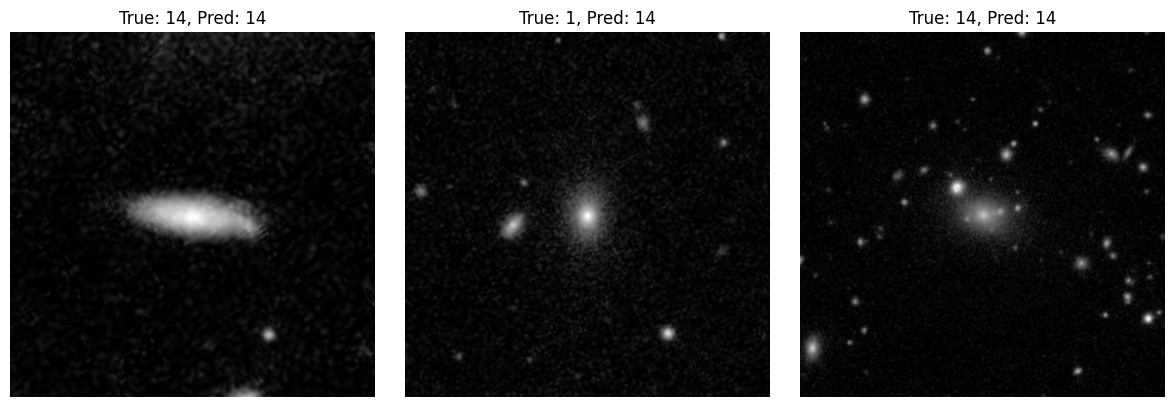

In [21]:
# Optional: Plot a few test images with their true and predicted labels
visualize_num = 3
plt.figure(figsize=(12, 4 * (visualize_num // 3)))

for i in range(visualize_num):
    img_name = os.path.join(train_data_path, f"{test_df['GalaxyID'].iloc[i]}.jpg")
    image = Image.open(img_name).convert('L')
    true_label = test_results_df['True_Label'].iloc[i]
    predicted_label = test_results_df['Predicted_Label'].iloc[i]

    plt.subplot(1, visualize_num, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}, Pred: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()